# Load dataset

In [1]:
import glob
import pandas as pd 

# Specify what folders do we need
INPUT_FOLDER      = './data_preprocessed4/'

list_df_metadata = []

# Find all files that ends with .csv, read and append to the list_df_metadata
for filename in glob.glob(INPUT_FOLDER + '*.csv'):
    df_data = pd.read_csv(filename)
    list_df_metadata.append(df_data)
    
df_metadata = pd.concat(list_df_metadata)
df_metadata = df_metadata.drop(['Unnamed: 0'], axis=1)
df_metadata = df_metadata.reset_index(drop=True)
df_metadata.head()

/home/zh.shakenov/miniconda3/envs/disser/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,lat,long,altitude,datetime,timedelta,distance,velocity,acceleration,trajectory_id,subfolder,...,a_ave,a_med,a_max,a_min,a_std,a_rol,a_rsd,a_qu1,a_qu2,a_qu3
0,40.061035,116.407049,64.0,2011-05-29 22:30:19,0 days 00:00:01.000000000,13.357307,13.357307,-0.810261,20110529222904,168,...,-0.029584,0.0,8.873882,-14.649245,0.731106,-0.193232,3.278783,-0.531929,0.024086,0.678226
1,40.060915,116.407060,65.0,2011-05-29 22:30:20,0 days 00:00:01.000000000,12.547046,12.547046,0.810261,20110529222904,168,...,-0.029584,0.0,8.873882,-14.649245,0.731106,-0.107458,3.269948,-0.333394,0.050601,0.784147
2,40.060802,116.407060,63.0,2011-05-29 22:30:21,0 days 00:00:01.000000000,13.357307,13.357307,-0.634696,20110529222904,168,...,-0.029584,0.0,8.873882,-14.649245,0.731106,-0.118051,3.271165,-0.531929,0.050601,0.784147
3,40.060682,116.407071,63.0,2011-05-29 22:30:22,0 days 00:00:01.000000000,12.722611,12.722611,-1.113277,20110529222904,168,...,-0.029584,0.0,8.873882,-14.649245,0.731106,-0.118465,3.271294,-0.531929,0.050601,0.784147
4,40.060568,116.407086,62.0,2011-05-29 22:30:23,0 days 00:00:01.000000000,11.609334,11.609334,-1.358473,20110529222904,168,...,-0.029584,0.0,8.873882,-14.649245,0.731106,-0.152541,3.278956,-0.618968,0.050601,0.784147


# Preprocessing

## 1. Drop nan values
As our main goal is predict labels, all irrelevant `nan` values would be dropped 

## 2. Drop all outliers
Due the processing that we had, there are some outliers in dataset, that can produce messy data

In [11]:
# 1. Drop nan values

print('Sample size before: ', len(df_metadata) // 1000, 'k')
df = df_metadata.dropna()
print('Sample size after:  ', len(df) // 1000 , 'k')

Sample size before:  23380 k
Sample size after:   4583 k


In [18]:
# How much drivers have data on some labels
# as we see that not all labels got variety of data source 
df.groupby('labels')['subfolder'].nunique()

labels
airplane       4
bike          31
boat           4
bus           41
car           35
motorcycle     2
run            3
subway        23
taxi          28
train         16
walk          57
Name: subfolder, dtype: int64

In [24]:
# 2. Show some outliers
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
%matplotlib inline

def show_boxes_plot(x, y, data):
    fig, ax = plt.subplots()
    fig.set_size_inches(11.7, 8.27)

    sns.boxplot(x=x, y=y, data=data,
               whis=np.inf, palette="vlag", ax=ax)
    sns.despine(trim=True, left=True)
    plt.show()

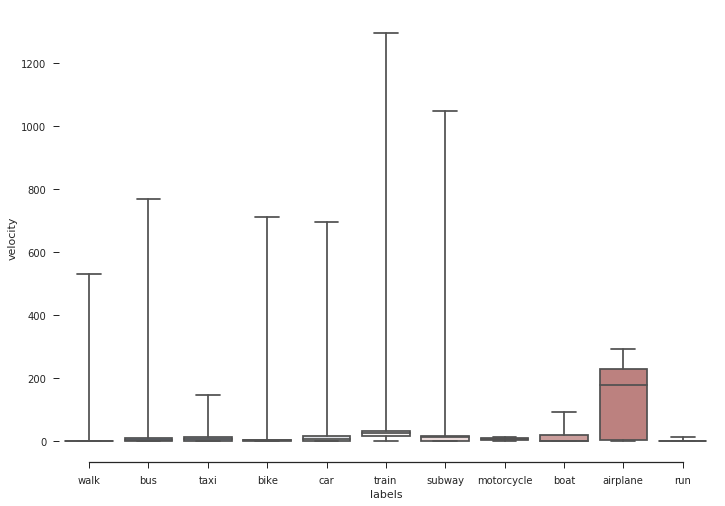

In [26]:
show_boxes_plot(x="labels", y="velocity", data=df)

In [105]:
# Filter data by quantiles
def get_filter(data, mode, column):
    lower = data[data['labels'] == mode][column].quantile(q=0.01)
    upper = data[data['labels'] == mode][column].quantile(q=0.99)
    
    print('Filter for ', column, ':', lower)
    print('Filter for ', column, ':', upper)
    return lower, upper

get_filter(df, 'walk', 'velocity')

Filter for  velocity : 0.0
Filter for  velocity : 11.150887909855143


(0.0, 11.150887909855143)

In [106]:
# Personal filters on mode 

def filterdata(data, modes, columns):
    for mode in modes:
        for column in columns:
            print(mode, column)
            lo, up = get_filter(data, mode, column)
            data = data[(data[column] > lo) & (data[column] < up)]
    return data

In [107]:
labels = list(df['labels'].unique())
labels.remove('motorcycle')
labels.remove('run')
labels.remove('boat')
labels.remove('airplane')
labels.remove('subway')

In [108]:

mindataset = df[df['labels'].isin(labels)]
map_min = {'airplane': 'airplane', 'bike': 'bike', 'subway': 'subway', 'train': 'train', 'run': 'run',
           'walk': 'walk', 'boat': 'boat', 'bus': 'vehicle', 'car': 'vehicle', 'taxi': 'vehicle'}
mindataset['labels'] = mindataset['labels'].apply(lambda x: map_min[x])

/home/zh.shakenov/miniconda3/envs/disser/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [109]:
print('Sample size after:  ', len(mindataset) // 1000 , 'k')

Sample size after:   4334 k


In [110]:
mindataset['labels'].unique()

array(['walk', 'vehicle', 'bike', 'train'], dtype=object)

In [111]:
X_columns = ['distance', 'velocity', 'acceleration',
             'v_rol', 'v_rsd', 'v_qu1', 'v_qu2', 'v_qu3',  
             'a_rol', 'a_rsd', 'a_qu1', 'a_qu2', 'a_qu3']
X_filter = ['velocity', 'acceleration', 'v_rol', 'a_rol']

Y_columns = ['labels']

labels = list(mindataset['labels'].unique())
print(labels)

['walk', 'vehicle', 'bike', 'train']


In [112]:
data = filterdata(mindataset, labels, X_filter)

walk velocity
Filter for  velocity : 0.0
Filter for  velocity : 11.150887909855143
walk acceleration
Filter for  acceleration : -1.7129690699920916
Filter for  acceleration : 1.8808978577408135
walk v_rol
Filter for  v_rol : 0.10837238354087333
Filter for  v_rol : 7.662593903756775
walk a_rol
Filter for  a_rol : -0.44732816293825794
Filter for  a_rol : 0.08370946734362893
vehicle velocity
Filter for  velocity : 0.04272133753444271
Filter for  velocity : 10.62903922638694
vehicle acceleration
Filter for  acceleration : -1.3145192656013975
Filter for  acceleration : 1.3798148347504686
vehicle v_rol
Filter for  v_rol : 0.24642301278359646
Filter for  v_rol : 7.548848272365875
vehicle a_rol
Filter for  a_rol : -0.29306952522660157
Filter for  a_rol : 0.07919494404706168
bike velocity
Filter for  velocity : 0.07004631697054069
Filter for  velocity : 6.917016125417037
bike acceleration
Filter for  acceleration : -1.1236431160171207
Filter for  acceleration : 1.1626063356584808
bike v_rol
Fil

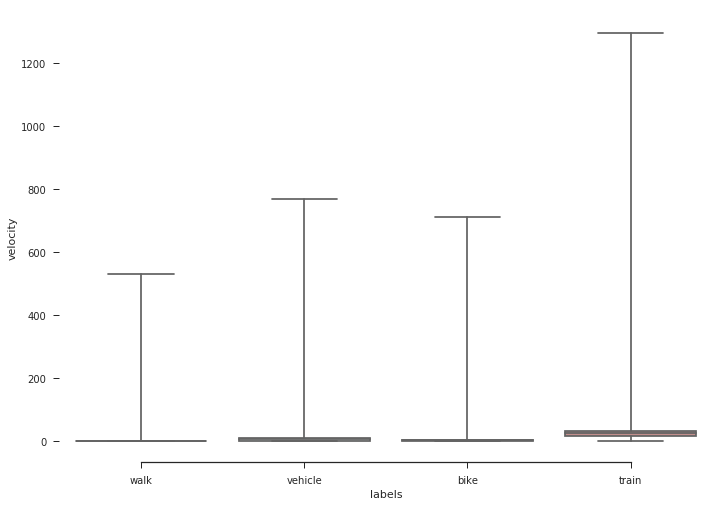

In [113]:
# Before processing
show_boxes_plot(x="labels", y="velocity", data=mindataset)

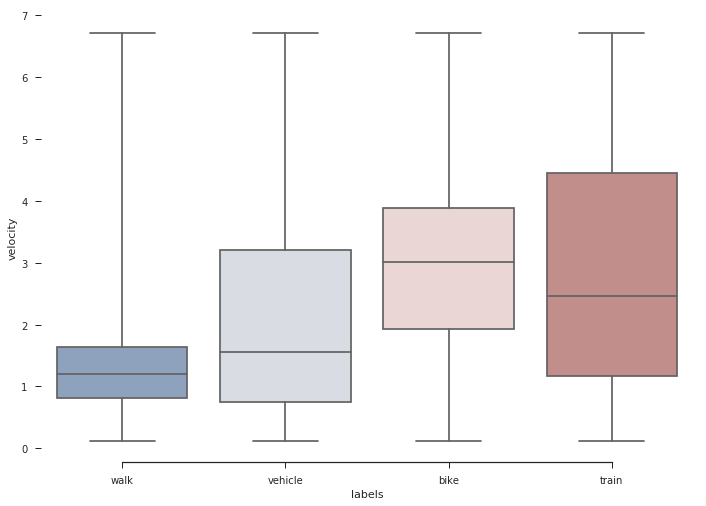

In [114]:
# After processing
show_boxes_plot(x="labels", y="velocity", data=data)

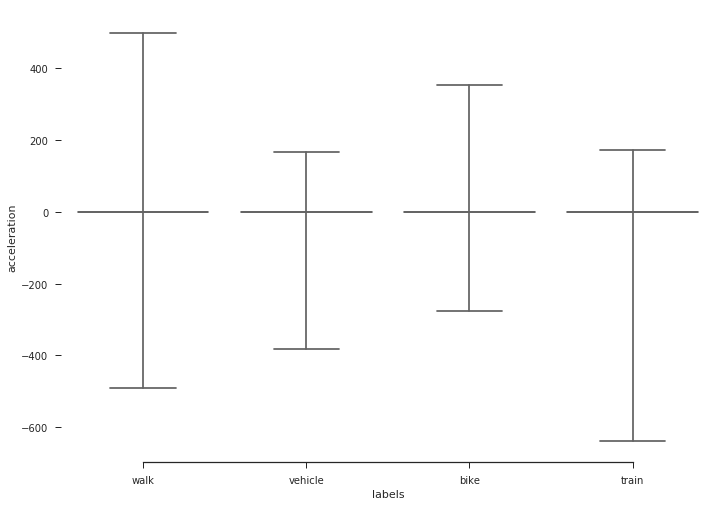

In [115]:
# Before processing
show_boxes_plot(x="labels", y="acceleration", data=mindataset)

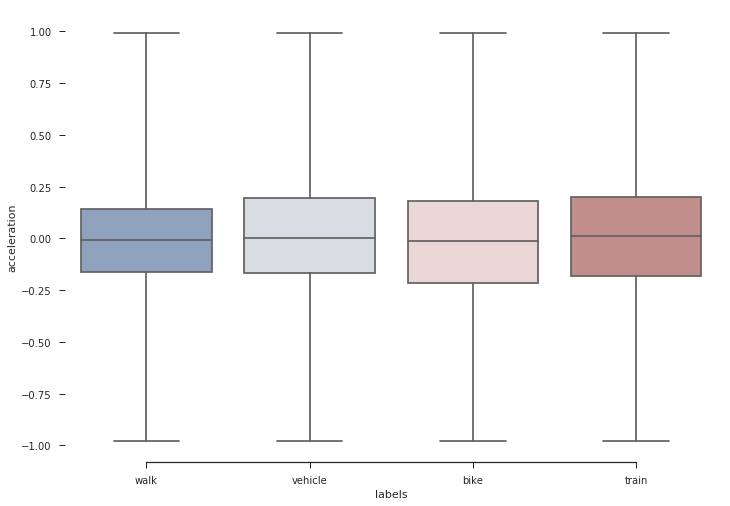

In [116]:
# After processing
show_boxes_plot(x="labels", y="acceleration", data=data)

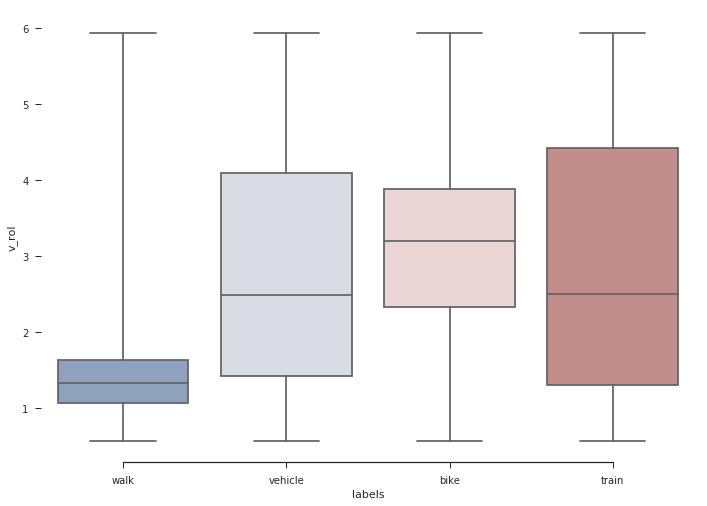

In [117]:
# After processing
show_boxes_plot(x="labels", y="v_rol", data=data)

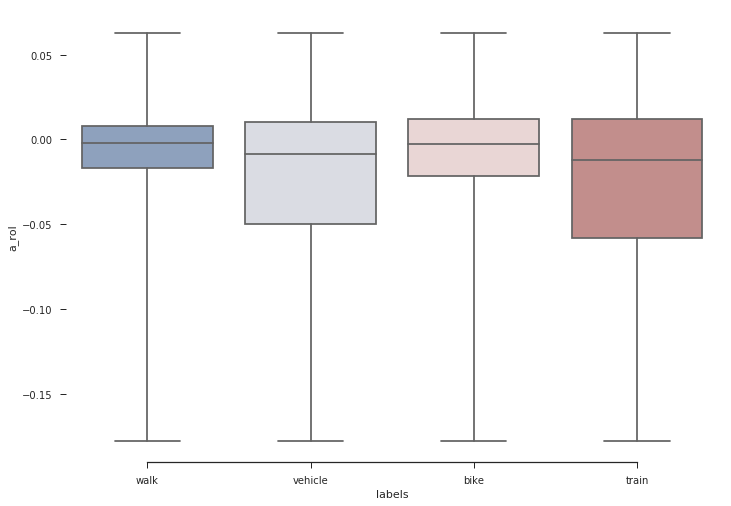

In [118]:
# After processing
show_boxes_plot(x="labels", y="a_rol", data=data)

# Model training
1. Data separation
2. Default model training
3. Parameter optimization

In [121]:
# 1. Data separation
from sklearn.model_selection import train_test_split

In [126]:
X = data[X_columns]
y = data[Y_columns]

In [130]:
state = 43

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=state)
X_train, X_validate, y_train, y_validate   = train_test_split(X_train, y_train, test_size=0.2, random_state=state)

In [131]:
print("Training samples: %d" % X_train.index.size)
print("Testing samples: %d" % X_test.index.size)
print("Validation samples: %d" % X_val.index.size)

Training samples: 1263156
Testing samples: 394737
Validation samples: 315789


### Обучение

Данные готовы, теперь можно обучить ML модель. Здесь мы в качестве модели используем [CatBoost](https://catboost.yandex/) - градиентный бустинг на деревьях решений
<img src="http://zdnet2.cbsistatic.com/hub/i/2017/07/18/d3f47c3e-8529-4855-a0e1-c686ee3b4007/d1113adf74bb59c3b46419a531c39c3e/orig.png" width=320>

Данный пример использует дефолтные настройки CatBoost-а. Вы можете их настраивать для получения лучшего результата, воспользовавшись [туториалом](https://tech.yandex.com/catboost/doc/dg/concepts/parameter-tuning-docpage/) по настройке параметров

In [142]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
y_train_tr = le.fit_transform(y_train)
y_test_tr = le.transform(y_test)
y_validate_tr = le.transform(y_validate)

/home/zh.shakenov/miniconda3/envs/disser/lib/python3.6/site-packages/sklearn/preprocessing/label.py:111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/zh.shakenov/miniconda3/envs/disser/lib/python3.6/site-packages/sklearn/preprocessing/label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [182]:
#if you don't have catboost installed, use !pip install catboost
from catboost import Pool, CatBoostClassifier

# fix seed to make reproducible results
seed=42

# Initialize CatBoostRegressor
model = CatBoostClassifier(random_seed=seed, loss_function='MultiClass',
                          learning_rate=0.5, depth=10, iterations=500, thread_count=15)
# Fit model
model.fit(
    X_train, y_train_tr, 
    eval_set=(X_validate, y_validate_tr)
)

0:	learn: -0.8470895	test: -0.8453908	best: -0.8453908 (0)	total: 1.16s	remaining: 9m 39s
1:	learn: -0.7436335	test: -0.7415604	best: -0.7415604 (1)	total: 2.58s	remaining: 10m 42s
2:	learn: -0.6936350	test: -0.6920568	best: -0.6920568 (2)	total: 4.03s	remaining: 11m 7s
3:	learn: -0.6670877	test: -0.6656247	best: -0.6656247 (3)	total: 5.43s	remaining: 11m 13s
4:	learn: -0.6523188	test: -0.6509928	best: -0.6509928 (4)	total: 6.83s	remaining: 11m 16s
5:	learn: -0.6421789	test: -0.6410218	best: -0.6410218 (5)	total: 8.24s	remaining: 11m 18s
6:	learn: -0.6352260	test: -0.6344410	best: -0.6344410 (6)	total: 9.62s	remaining: 11m 17s
7:	learn: -0.6305569	test: -0.6300531	best: -0.6300531 (7)	total: 11s	remaining: 11m 18s
8:	learn: -0.6267438	test: -0.6264527	best: -0.6264527 (8)	total: 12.4s	remaining: 11m 19s
9:	learn: -0.6234487	test: -0.6233918	best: -0.6233918 (9)	total: 13.8s	remaining: 11m 17s
10:	learn: -0.6209962	test: -0.6213177	best: -0.6213177 (10)	total: 15.2s	remaining: 11m 16s
1

89:	learn: -0.5489789	test: -0.5715972	best: -0.5715972 (89)	total: 2m 6s	remaining: 9m 35s
90:	learn: -0.5483276	test: -0.5712395	best: -0.5712395 (90)	total: 2m 7s	remaining: 9m 33s
91:	learn: -0.5477894	test: -0.5709855	best: -0.5709855 (91)	total: 2m 9s	remaining: 9m 32s
92:	learn: -0.5473013	test: -0.5706377	best: -0.5706377 (92)	total: 2m 10s	remaining: 9m 30s
93:	learn: -0.5468124	test: -0.5703750	best: -0.5703750 (93)	total: 2m 11s	remaining: 9m 29s
94:	learn: -0.5461743	test: -0.5700920	best: -0.5700920 (94)	total: 2m 13s	remaining: 9m 28s
95:	learn: -0.5456524	test: -0.5698455	best: -0.5698455 (95)	total: 2m 14s	remaining: 9m 26s
96:	learn: -0.5450659	test: -0.5694489	best: -0.5694489 (96)	total: 2m 16s	remaining: 9m 25s
97:	learn: -0.5446308	test: -0.5692429	best: -0.5692429 (97)	total: 2m 17s	remaining: 9m 24s
98:	learn: -0.5441385	test: -0.5689195	best: -0.5689195 (98)	total: 2m 18s	remaining: 9m 22s
99:	learn: -0.5437834	test: -0.5687272	best: -0.5687272 (99)	total: 2m 20

176:	learn: -0.5104423	test: -0.5523060	best: -0.5523060 (176)	total: 4m 8s	remaining: 7m 34s
177:	learn: -0.5102800	test: -0.5522731	best: -0.5522731 (177)	total: 4m 10s	remaining: 7m 32s
178:	learn: -0.5098642	test: -0.5520218	best: -0.5520218 (178)	total: 4m 11s	remaining: 7m 31s
179:	learn: -0.5093971	test: -0.5517905	best: -0.5517905 (179)	total: 4m 13s	remaining: 7m 30s
180:	learn: -0.5090256	test: -0.5517352	best: -0.5517352 (180)	total: 4m 14s	remaining: 7m 28s
181:	learn: -0.5087683	test: -0.5516241	best: -0.5516241 (181)	total: 4m 16s	remaining: 7m 27s
182:	learn: -0.5084651	test: -0.5514478	best: -0.5514478 (182)	total: 4m 17s	remaining: 7m 26s
183:	learn: -0.5079984	test: -0.5511935	best: -0.5511935 (183)	total: 4m 18s	remaining: 7m 24s
184:	learn: -0.5076401	test: -0.5509940	best: -0.5509940 (184)	total: 4m 20s	remaining: 7m 23s
185:	learn: -0.5070712	test: -0.5506296	best: -0.5506296 (185)	total: 4m 21s	remaining: 7m 21s
186:	learn: -0.5067489	test: -0.5504669	best: -0.55

263:	learn: -0.4807394	test: -0.5401011	best: -0.5401011 (263)	total: 6m 12s	remaining: 5m 32s
264:	learn: -0.4804828	test: -0.5400371	best: -0.5400371 (264)	total: 6m 13s	remaining: 5m 31s
265:	learn: -0.4802541	test: -0.5399723	best: -0.5399723 (265)	total: 6m 15s	remaining: 5m 30s
266:	learn: -0.4800185	test: -0.5399104	best: -0.5399104 (266)	total: 6m 16s	remaining: 5m 28s
267:	learn: -0.4796494	test: -0.5397477	best: -0.5397477 (267)	total: 6m 17s	remaining: 5m 27s
268:	learn: -0.4794352	test: -0.5396623	best: -0.5396623 (268)	total: 6m 19s	remaining: 5m 25s
269:	learn: -0.4790532	test: -0.5395071	best: -0.5395071 (269)	total: 6m 20s	remaining: 5m 24s
270:	learn: -0.4785645	test: -0.5392347	best: -0.5392347 (270)	total: 6m 22s	remaining: 5m 22s
271:	learn: -0.4782714	test: -0.5390962	best: -0.5390962 (271)	total: 6m 23s	remaining: 5m 21s
272:	learn: -0.4779543	test: -0.5388993	best: -0.5388993 (272)	total: 6m 25s	remaining: 5m 20s
273:	learn: -0.4775852	test: -0.5388691	best: -0.5

350:	learn: -0.4540383	test: -0.5297920	best: -0.5297920 (350)	total: 8m 15s	remaining: 3m 30s
351:	learn: -0.4538340	test: -0.5297388	best: -0.5297388 (351)	total: 8m 17s	remaining: 3m 29s
352:	learn: -0.4535360	test: -0.5296438	best: -0.5296438 (352)	total: 8m 18s	remaining: 3m 27s
353:	learn: -0.4533432	test: -0.5296351	best: -0.5296351 (353)	total: 8m 20s	remaining: 3m 26s
354:	learn: -0.4531104	test: -0.5296177	best: -0.5296177 (354)	total: 8m 21s	remaining: 3m 24s
355:	learn: -0.4529329	test: -0.5295579	best: -0.5295579 (355)	total: 8m 22s	remaining: 3m 23s
356:	learn: -0.4527199	test: -0.5295048	best: -0.5295048 (356)	total: 8m 24s	remaining: 3m 22s
357:	learn: -0.4525385	test: -0.5294449	best: -0.5294449 (357)	total: 8m 25s	remaining: 3m 20s
358:	learn: -0.4523481	test: -0.5294147	best: -0.5294147 (358)	total: 8m 27s	remaining: 3m 19s
359:	learn: -0.4521050	test: -0.5293410	best: -0.5293410 (359)	total: 8m 28s	remaining: 3m 17s
360:	learn: -0.4516418	test: -0.5291262	best: -0.5

437:	learn: -0.4308076	test: -0.5215110	best: -0.5215110 (437)	total: 10m 19s	remaining: 1m 27s
438:	learn: -0.4305817	test: -0.5213947	best: -0.5213947 (438)	total: 10m 21s	remaining: 1m 26s
439:	learn: -0.4303912	test: -0.5213244	best: -0.5213244 (439)	total: 10m 22s	remaining: 1m 24s
440:	learn: -0.4301525	test: -0.5212284	best: -0.5212284 (440)	total: 10m 23s	remaining: 1m 23s
441:	learn: -0.4298060	test: -0.5210300	best: -0.5210300 (441)	total: 10m 25s	remaining: 1m 22s
442:	learn: -0.4295045	test: -0.5208625	best: -0.5208625 (442)	total: 10m 26s	remaining: 1m 20s
443:	learn: -0.4292532	test: -0.5207993	best: -0.5207993 (443)	total: 10m 28s	remaining: 1m 19s
444:	learn: -0.4289557	test: -0.5206806	best: -0.5206806 (444)	total: 10m 29s	remaining: 1m 17s
445:	learn: -0.4287546	test: -0.5206257	best: -0.5206257 (445)	total: 10m 31s	remaining: 1m 16s
446:	learn: -0.4285496	test: -0.5205813	best: -0.5205813 (446)	total: 10m 32s	remaining: 1m 14s
447:	learn: -0.4282278	test: -0.5204571	

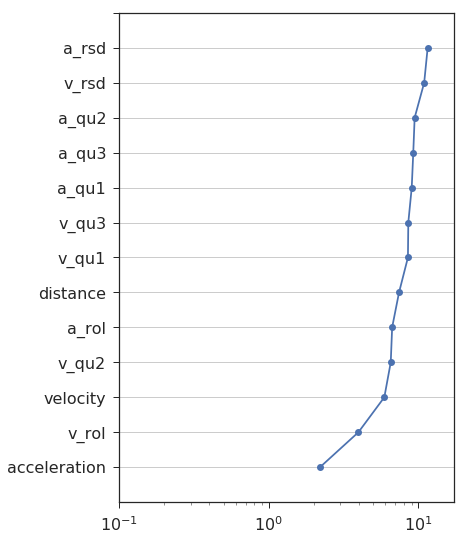

In [183]:
# first 20 important features
TOP_FEATURES_NUMBER = 20

order = np.argsort(model._feature_importance)[-TOP_FEATURES_NUMBER:]
plt.figure(figsize=[6,9])
plt.plot(np.array(model._feature_importance)[order],range(len(order)),marker='o')
plt.yticks(range(TOP_FEATURES_NUMBER),X_train.columns[order]);
plt.tick_params(labelsize=16)
plt.xlim([0.1,max(model._feature_importance)*1.5])
plt.ylim(-1,len(order))
plt.grid(True, axis='y')
plt.xscale('log')

### Применение и оценка результатов
Применим полученную модель к нашему тесту

In [184]:
predictions = model.predict(X_test)
print(predictions)
# test_pool_df = test_pool_df.copy()
# test_pool_df.loc[:, 'predictions'] = predictions

[[2.]
 [0.]
 [0.]
 ...
 [3.]
 [3.]
 [0.]]


In [185]:
y = y_test_tr.reshape(-1, 1)
y.shape

(394737, 1)

In [186]:
predictions.shape

(394737, 1)

In [187]:
sum(predictions == y) / (len(predictions))

array([0.80698288])

In [188]:
from sklearn.metrics import classification_report

print(classification_report(y, predictions))

             precision    recall  f1-score   support

          0       0.86      0.79      0.83    108181
          1       0.83      0.37      0.51      2748
          2       0.81      0.65      0.72    102934
          3       0.78      0.91      0.84    180874

avg / total       0.81      0.81      0.80    394737



In [201]:
# model.save_model('', format="CPP")
model.save_model(
    "models/catboost/2.mlmodel",
    format="cbm"
)


In [203]:
model2 = CatBoostClassifier().load_model("models/catboost/2.mlmodel")

In [215]:
res =model2.predict(X_test)

In [208]:
# save columns
np.save("models/catboost/2-headers.mlmodel", le.classes_)

In [213]:
encoder = preprocessing.LabelEncoder()
encoder.classes_ = np.load('./models/catboost/2-headers.mlmodel.npy')

In [220]:
encoder.inverse_transform(res.astype(int))

/home/zh.shakenov/miniconda3/envs/disser/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


array([['vehicle'],
       ['bike'],
       ['bike'],
       ...,
       ['walk'],
       ['walk'],
       ['bike']], dtype=object)

array([[2],
       [0],
       [0],
       ...,
       [3],
       [3],
       [0]])